# Homework #3 (Due 10/2/2019, 11:59pm)
## EM for Data Augmentation; MCMC Sampling

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Dimitris Vamvourellis**

**Students collaborators: Rylan Schaeffer**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [64]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
import scipy as sp
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

---

# Problem Description: Latent Variables for Data Augmentation

A botany research lab in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to study the genetic factor that creates an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each. 

Out of 197 initial cross-breedings, the nursery obtained the following counts of the four types of child plants:

$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$

where $y_i$ represents the number of child plants that are of type $i$.

The geneticist in the lab know that the probability of obtaining each type of child plant in any single breeding experiment is correlated by the inheritability $\theta$ of a specific genetic factor. That is, the probabilities of obtaining the four subtypes are as follows:

$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4},$$

where $\theta \in [0, 1]$ is unknown.

The lab chose to model the observed data using a multinomial model:

\begin{align}
Y & \sim Mult\left(197, \left[\frac{\theta+2}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{align}

The aim of this problem is to estimate $\theta$ from the observed counts.

## Part I: MLE Through Latent Variable Augmentation and EM
In models where directly computing the MLE is hard (you can think about if that is the case here), the optimization of the likelihood can often be simplified by introducing a latent variable into the model and then optimize the liklelihood using EM - this process is called ***data augmentation***.

The nursery augmented the data with a new variable $Z$ such that:
$$Z + (y_1 - Z) = y_1.$$
That is, using $Z$, they are breaking $y_1$, the number of Type I child plants, into two subtypes, with $Z$ being the count of Subtype #1 and $(y_1-Z)$ being the count of Subtype #2. The lab posited the probability of obtain the two subtype $\theta/4$ and $1/2$, respectively.

The augmented model (which includes the observed data $y$ and the latent variable $z$ they introduced) they derived is as follows:

\begin{aligned}
Z | Y, \theta &\sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)\\
Y & \sim Mult\left(197, \left[\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{aligned}

1. Show that the assumptions the lab made about $Z$ implies that $Z | Y, \theta \sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)$.<br><br>

2. Derive the EM updates for the augmented latent variable model.<br><br>

3. Implement the EM algorithm to estimate the MLE of $\theta$. Choose an appropriate initialization point and an appropriate stopping condition.<br><br>

4. Explain the potential advantage of augmenting likelihood models with a latent variable (e.g. what aspects of the MLE computation becomes easier or more efficient?).

**ANSWERS**

**1.** According to the lab, when having a Type 1 child plant, the probability of this being of Subtype #1 is $\frac{\theta}{4}$ and the probability of this being of Subtype #2 is $\frac{1}{2}$. Hence, we can model the count $Z$ of Subtype #1 plants out of $y_1$ total Type 1 child plants with a binary distribution. But to get a valid distribution, the probabilities have to add up to one. Hence, given that the plant is of Type I, the probability of it being of Subtype #1 is 

$$\frac{\frac{\theta}{4}}{\frac{\theta}{4}+\frac{1}{2}} = \frac{\frac{\theta}{4}}{\frac{\theta+2}{4}} = \frac{\theta}{2+\theta}$$

Hence the number $Z$ of Subtype #1 plants out of $y_1$ total Type I child plants follows a binary distribution $Z | Y, \theta \sim Bin(y_1, \frac{\theta}{2 + \theta})$

**2.** We have introduced a latent variable $Z$ by splitting the first category in two. In other words, we observe the total number of Type 1 plants, $y_1$, but we don't observe how many of them are of Subtype #1. Hence, we can rewrite the distribution of observations $Y$ as follows:

$$Y = (Z, y_1-Z, y_2, y_3, y_4, y_5) \sim Mult(197, [\frac{1}{2}, \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4}])$$

So in the E-step, we want to calculate the auxiliary function:

$$Q(\theta|\theta_{\text{old}}) = \mathbb{E}_{Z\sim p(Z|Y, \theta_{\text{old}})}\left[\log \left( p(y, Z |\theta\right) \right]$$

The term in the expectation is the complete data log-likelihood. Let's first derive the complete likelihood of observed and latent variables as shown below.

$$L(Y, Z |\theta) = \frac{N!}{Z!(y_1-Z)!y_2!y_3!y_4!}(\frac{1}{2})^Z(\frac{\theta}{4})^{y_1-Z}(\frac{1-\theta}{4})^{y_2}(\frac{1-\theta}{4})^{y_3}(\frac{\theta}{4})^{y_4}$$

Hence, if we bundle together any terms not depending on $\theta$ in $const$, the complete data log-likelihood is given by

$$\ell(Y, Z |\theta) = log(L(Y, Z |\theta)) = const + (y_1-Z)log(\frac{\theta}{4}) + y_2 log(\frac{1-\theta}{4}) + y_3 log(\frac{1-\theta}{4}) + y_4 log(\frac{\theta}{4})$$

Then, we can rewrite $Q(\theta|\theta_{\text{old}})$ as follows:
\begin{aligned}
Q(\theta|\theta_{\text{old}})= \mathbb{E}_{Z\sim p(Z|Y, \theta_{\text{old}})}\left[\ell(Y, Z
|\theta) \right] =const + y_1 log(\frac{\theta}{4}) - \mathbb{E}_{Z\sim p(Z|Y, \theta_{\text{old}})}[Zlog(\frac{\theta}{4}))] +y_2log(\frac{1-\theta}{4}) + y_3 log(\frac{1-\theta}{4})+y_4 log(\frac{\theta}{4})
\end{aligned}

Since $Z | Y, \theta \sim Bin(y_1, \frac{\theta}{2 + \theta})$, the mean $Z$ is $\frac{y_1\theta}{2 + \theta}$.

Hence, 

$$Q(\theta|\theta_{\text{old}}) = const + y_1 log(\frac{\theta}{4}) - \frac{y_1\theta_{\text{old}}}{2+\theta_{\text{old}}}log(\frac{\theta}{4}) +y_2log(\frac{1-\theta}{4}) + y_3 log(\frac{1-\theta}{4})+y_4 log(\frac{\theta}{4}) = $$
$$ = const + (y_1-\frac{y_1\theta_{\text{old}}}{2 + \theta_{\text{old}}}+y_4)log(\theta)+(y_3+y_4)log(1-\theta) = $$
$$ = const + (y_{12}+y_4)log(\theta)+(y_3+y_4)log(1-\theta), $$

where $y_{12} = \frac{y_1\theta_{\text{old}}}{2 + \theta_{\text{old}}}$.

In the M-step, we maximize this auxiliary function w.r.t. $\theta$ by taking the derivative of $Q$ w.r.t. $\theta$ and setting equal to 0 as follows:


$$\frac{\partial Q}{\partial \theta} = 0$$
$$\implies \frac{1}{\theta}(y_{12}+y_4) = (y_2+y_3)\frac{1}{1-\theta}$$
$$\implies \theta = \frac{y_{12}+y_4}{y_{12}+y_2+y_3+y_4}$$

To summarize, we first initialiaze $\theta$ to $\theta_0$. Then, we iterate by going through E-step and M-step doing the following updates:

E-step: $$y_{12_{\text{i+1}}} = \frac{y_1\theta_{\text{i}}}{2 + \theta_{\text{i}}},$$

M-step: $$\theta_{\text{i+1}} = \frac{y_{12_{\text{i+1}}}+y_4}{y_{12_{\text{i+1}}}+y_2+y_3+y_4}.$$ 



**3.**

In [256]:
#initialization
theta_init = 0
theta_current = theta_init
iterations = 1000
Y = np.array([125, 18, 20, 34])
tolerance = 10e-6
for i in range(iterations):
    #E-step calcualte new y12
    y12 = Y[0]*theta_current/(theta_current+2.)
    #M-Step maximize with respect to theta
    theta_next = (y12 + Y[3])/(y12 + Y[1] + Y[2] + Y[3])
    #stop if the estimate does not improve by tolerated amount
    if np.abs(theta_next - theta_current)>= tolerance:
        theta_current = theta_next
    else:
        break

print(f"After {i+1} iterations, theta as approximated by EM is: {theta_current}")

After 7 iterations, theta as approximated by EM is: 0.6268141531594963


**4.** In this case, if we had to calculate the MLE estimate without augmenting a latent variable, we would need to solve the following equation to find the MLE estimate of $\theta$. 

$$\frac{y_1}{\theta+2} - \frac{y_2+y+3}{1-\theta} + \frac{y_4}{\theta} = 0$$

It is clear that to solve this equation we would need to solve a second-degree equation. On the contrary, after introducing the latent variable, the maximization problem in the M-step just involves linear parameters in $\theta$ making the problem much easier. Motivated by this toy problem, we can see that a potential advantage of augmenting likelihood models with latent variables could make the equation to be solved for maximization easier.

---

# Problem Description: Modeling Kidney Cancer Data
In this problem, we will work with the US Kidney Cancer Data set, `kcancer.csv`. This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

**In this homework, we focus on the mechanics of seting up a statistical model for this data set and performing inference on it. In the next homework, we will focus on interpreting this model and comparing it with others in context.**

Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}

where $\alpha, \beta$ are hyper-parameters of the model.


Rather than arbitrarily choosing the hyperparameters $\alpha, \beta$, following the Bayesian philosophy, we typically put additional priors on quantities of which we are uncertain. That is, we model the kidney cancer rates using a ***hierarchical model***:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

In this problem, you will implement a modified Gibbs sampler to sample from the posterior of this complex model.

## Part I: The Conditional Distributions
1. Justify our choice to use a hierarchical model. Specifically, explain the draw-backs of using MLE estimates of $\theta_j$ to represent the underlying cancer rates of these counties (recall the discussion in Lecture #3). Explain the draw-backs of choosing specific values for the hyper-parameters of $\alpha$ and $\beta$ rather than putting priors on them (recall the discussion in Homework #1 about priors).<br><br>

2. Verify that the conditional distributions are 
\begin{align}
p(\theta_j | \theta_{-j}, y, \alpha, \beta) &= Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta),\\
p(\alpha, \beta | \theta, y) &\propto \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}
\end{align}
  where we use the following notation:
\begin{align}
\theta &:= \{ \theta_j\}_{j=1, \ldots, N}\\
\theta_{-j} &:= \{ \theta_j\}_{j=1, j-1, j,\ldots, N}\\
y &:= \{y_j \}_{j=1, \ldots, N}\\
y_{-j} &:= \{ y_j\}_{j=1, j-1, j,\ldots, N}\\
\end{align}
  Unfortunately, you see that $p(\alpha, \beta | \theta, y)$ doesn't resemble the pdf of a nice simple distribution; that is, it is unclear how to sample from it.

**1.** The main drawback of using MLE estimates becomes apparent when the sample size of data that we have is small. In such cases, MLE estimates overfit the data and may provide significantly inconsistent estimates. For example, consider the case of a small county (like the most of counties in rural regions) with population of about 1000 residents. If there is just 1 person with kidney cancer, the MLE estimate of cancer rate would be 1/1000. However, if there was no person with kidney cancer, the rate would be 0, which is a big difference when counting the rates of rare events. 

To provide another example, if a large urban county with high population (e.g. over 100000) has a cancer rate of 1/1000, it is unlikely that this is a random event. However, in a small sample, having one instance of kidney cancer is probably a random event. If we used MLE estimates, in such a case, the small rural county cancer rate would be equal to the one on the big urban county leading us to biased conclusions.

Regarding priors, if we chose specific values for $\alpha$ and $\beta$ we constrain the prior distribution of $\theta$ to a range of possible values for every possible county. In other words, if we wanted to encode different prior knowledge for each county, we would need to set specific values for $\alpha$ and $\beta$ for each county which is not an easy task. Instead, by setting flat wide priors on each parameter $\alpha$ and $\beta$ of the prior distribution of $\theta_j$, we add flexibility by allowing a-priori a larger number of possible models independent of the characteristics of each county. In other words, by introducing another layer of prior beliefs on the parameters of the distribution of $\theta_j$, we can fit more complex models which capture the different socioeconomic characteristics of each county.

**2.** By applying Bayes Rule and conditional independence as given by the hierarchical model, we have 

$$p(\theta_j | \theta_{-j}, y_j, \alpha, \beta) \propto p(y_j|\theta_j)p(\theta_j|\alpha,\beta)p(\alpha)p(\beta)$$

By collenting any constant terms not depending on $\theta_j$ in $const$ we obtain

$$p(y_j|\theta_j)p(\theta_j|\alpha,\beta)p(\alpha)p(\beta) \propto const *  e^{-5n_j \theta_j} * (5n_j \theta_j)^{y_j} * \theta_j^{\alpha - 1} e^{-\beta\theta_j} \propto const * \theta_j^{y_j + \alpha - 1} *  e^{-(5n_j+\beta)\theta_j}$$

From the form of the posterior, we can verify that it is a $Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta)$ distribution.


Similarly, by applying Bayes rule and conditional independence, we have

$$p(\alpha, \beta | \theta, y) \propto \prod_{j=1}^N [p(\theta_j|\alpha,\beta)]p(\alpha)p(\beta) = $$
$$ = \prod_{j=1}^N \frac{\beta^{\alpha}}{\Gamma(\alpha)} \theta_j^{\alpha-1} e^{-\beta \theta_j} \frac{b^a}{\Gamma(a)} \alpha^{a-1} e^{-b\alpha} \frac{d^c}{\Gamma(c)} \beta^{c-1} e^{-d \beta} = $$
$$ = \frac{b^a}{\Gamma(a)} \frac{d^c}{\Gamma(c)} \frac{\beta^{N\alpha}}{[\Gamma(\alpha)]^N} \prod_{j=1}^N\left[\theta_j^{\alpha-1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1} $$
$$\propto \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}$$



## Part II: Metropolis-Hastings-in-Gibbs
1. When one or more conditional distributions in a Gibbs sampler do not have closed forms (this is the case for most models), we often sample from these conditionals using another MCMC method (e.g. Metropolis Hastings). That is, we modify the Gibbs sampler as follows:

  **I.** Sample $\theta_j$ using the closed form for $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$.
  
  **II.** Sample $\alpha, \beta$ from $p(\alpha, \beta | \theta, y)$ using a Metropolis-Hastings step (i.e. use a proposal distribution to propose a sample and the MH reject/accept mechanism to accept the new sample or keep the old).
  
  This algorithm is called a ***Metropolis-Hastings-in-Gibbs sampler***. <br><br>
  
  Note that we computed $p(\alpha, \beta | \theta, y)$ only up to a constant. Show why we don't need to know the normalizing constant of $p(\alpha, \beta | \theta, y)$ when we perform MH sampling.<br><br>
  
3.  Implement and run a Metropolis-Hastings-in-Gibbs sampler for the kidney cancer model.

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = 1.54517349188, \beta_0 = 133514.171939$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10<br><br>
  
4. Check for and discuss the convergence of your sampler. If you think your sampler has converged, explain why. If you believe your sampler has not converged, explain what next steps you might take to determine which design choices were problemmatic.
  
  **Important Disclaimer:** Convergence in a untweaked sampler may be unlikely after only 100,000 Gibbs sweeps. We are not asking you in this homework to achieve convergence, but you must demonstrate that you know how to perform diagnostics on your sampler.<br><br>
  
  
**Extra Credit:** Tweak the settings in your sampler (e.g. number of sweeps) in order to achieve reasonable confidence that your sampler has converged. Reconsider also other design choices like, do you need to sample $\alpha$ and $\beta$ jointly?<br><br>

**Extra Credit:** Prove the correctness of Metropolis-Hastings-in-Gibbs sampler. You need to state the definition of the correctness of an MCMC sampler and prove that Metropolis-Hastings-in-Gibbs sampler satisfy these properties.

**ANSWERS**

**1.** To get samples from the posterior $p(\alpha, \beta | \theta, y)$ using MH, we have to calculate the acceptance probability given by

$$acceptance(\alpha_{\text{prop}}, \beta_{\text{prop}}, \alpha_{\text{old}}, \beta_{\text{old}} ) = \min\left(1, \frac{p(\alpha_{\text{prop}}, \beta_{\text{prop}} | \theta, y)/q(\alpha_{\text{prop}}, \beta_{\text{prop}} | \alpha_{\text{old}}, \beta_{\text{old}})}{p(\alpha_{\text{old}}, \beta_{\text{old}} | \theta, y)/ q(\alpha_{\text{old}}, \beta_{\text{old}}| \alpha_{\text{prop}}, \beta_{\text{prop}})}\right),$$

where $p(\alpha, \beta | \theta, y)$ and $q(\alpha_{prop}, \beta_{prop} | \alpha_{old}, \beta_{old})$ is the proposal distribution. Since the normalization constant of the posterior is included in both the numerator and the denominator of the ratio in the above acceptance probability term, it can be crossed out. Hence, we don't need to know the normalization constant in first place to compute the acceptance probability. 

**2.**

In [39]:
cancer_df = pd.read_csv('kcancer.csv')
cancer_df.head(5)

,state,fips,county,countyfips,dc,pop,pct_mortality
0,ALABAMA,1,AUTAUGA,1001,1.0,64915.0,0.000015
1,ALABAMA,1,BALDWIN,1003,15.0,195253.0,0.000077
2,ALABAMA,1,BARBOUR,1005,1.0,33987.0,0.000029
3,ALABAMA,1,BIBB,1007,1.0,31175.0,0.000032
4,ALABAMA,1,BLOUNT,1009,5.0,91547.0,0.000055


In [216]:
#set the number of observations of cancer rates
N = cancer_df.shape[0]

def MH_in_gibbs(S, log_target, a_init, b_init, df, Sigma, a, b, c, d, burn_in_proportion, thinning):
    #get the cancer cases and populations from the dataset
    y = df['dc'].values
    populations = df['pop'].values
    N = y.shape[0]
    #initialize the values of alpha and beta
    current = np.array([a_init, b_init])
    #initialize the list that holds the samples of alpha and beta
    a_b_samples = []
    #initialize thetas array with initial theta_j = y_j/n_j for each county j
    thetas = np.zeros(N)
    for i in range(N):
        #add 1 to the numerator to handle cases in which a county will have 0 incidences
        thetas[i] = (y[i]+1.0)/populations[i]
    j = 0
    for i in range(S):
        #sample one theta_j and change it in place in the array of thetas
        thetas[j] = np.random.gamma(current[0] + y[j], 1.0/(5*populations[j] + current[1]), size=1)[0]       
        #make sure that in each iteration the next theta_j is sampled 
        j += 1
        j = j % N
        #use MH sampling to draw samples from the posterior over alpha, beta
        #first propose a point from a normal with mean the current [a,b]
        proposal = np.random.multivariate_normal(current, Sigma)
        U = np.random.uniform(0, 1)
        #the proposal is symmetric so we can drop q terms from the ratio term of acceptance prob
        diff = log_target(proposal, N, thetas, a, b, c, d) - log_target(current, N, thetas, a, b, c, d)
        ratio = np.exp(diff)
        if U < np.min((1, ratio)):
            a_b_samples.append(proposal)
            current = proposal
        else:
            a_b_samples.append(current)
    #burn the first burn_in_proportion*S samples and thin, then return the array of samples
    burn_in_samples = int(burn_in_proportion*S)
    return np.array(a_b_samples)[burn_in_samples::thinning, :]


#function to calculate the log of the posterior over alpha, beta up to a normalizing constant
#prop (np.array): 2x1 array which holds alpha, beta for which we evaluate the target
#N (int): number of counties
#thetas (np.array): Nx1 array which holds thetas for each county
#a, b, c, d (float): parameters of the priors on alpha and beta
def log_target(prop, N, thetas, a, b, c, d):
    #calculate the terms of the expression we derived for the posterior over (a,b) and sum them
    alpha = prop[0]
    beta = prop[1]
    term1 = N*alpha*np.log(beta) - N*np.log(sp.special.gamma(alpha))
    term2 = (alpha-1) * np.log(thetas).sum()
    term3 = -d*beta - b*alpha - beta*thetas.sum()
    term4 = (a-1)*np.log(alpha) + (c-1)*np.log(beta)
    return term1+term2+term3+term4

#plot the samples of alpha and beta for the given burn in proportion and thinning
def plot_samples(samples, burn_in, thin):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(range(len(samples)), samples[:,0], color='red', alpha=0.5)
    ax[0].set_title('Trace plot of alpha (burn-in proportion: {}, thinning: {})'.format(burn_in, thin))
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel(r'$\alpha$')
    ax[1].plot(range(len(samples)), samples[:,1], color='red', alpha=0.5)
    ax[1].set_title('Trace plot of beta (burn-in proportion: {}, thinning: {})'.format(burn_in, thin))
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel(r'$\beta$')
    

Below, we are running MH-in-Gibbs for 100000 sweeps and the suggested initializations. First, we provide results without any burn in or thinning.

In [209]:
S=100000
a_init = 1.54517349188
b_init = 133514.171939
Sigma = np.array([[0.1, 0],[0, 1000]])
a = 9
b = 6 
c = 9
d = 0.00001
burn_in_prop = 0
thinning = 1

samples = MH_in_gibbs(S, log_target, a_init, b_init, cancer_df, Sigma, a, b, c, d, burn_in_prop, thinning)

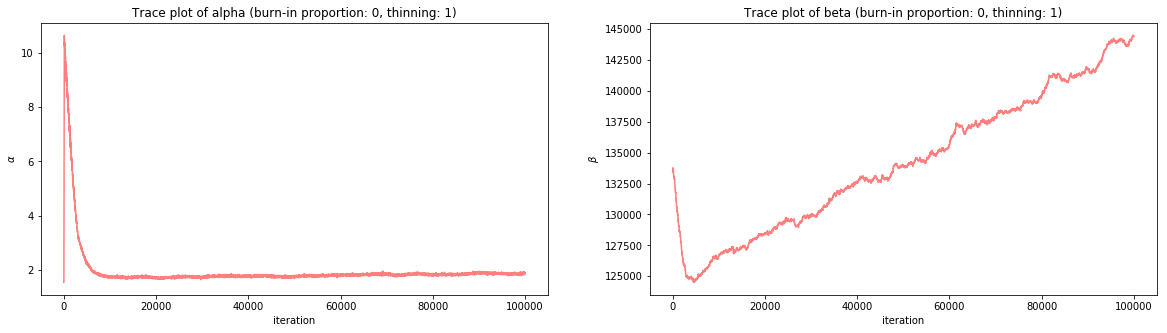

In [217]:
plot_samples(samples, 0, 1)

Below, we provide results after burning the first 10000 samples and applying a thinning factor of 10.

In [206]:
S=100000
a_init = 1.54517349188
b_init = 133514.171939
Sigma = np.array([[0.1, 0],[0, 1000]])
a = 9
b = 6 
c = 9
d = 0.00001
burn_in = 0.1
thinning = 10

burnthin_samples = MH_in_gibbs(S, log_target, a_init, b_init, cancer_df, Sigma, a, b, c, d, burn_in, thinning)

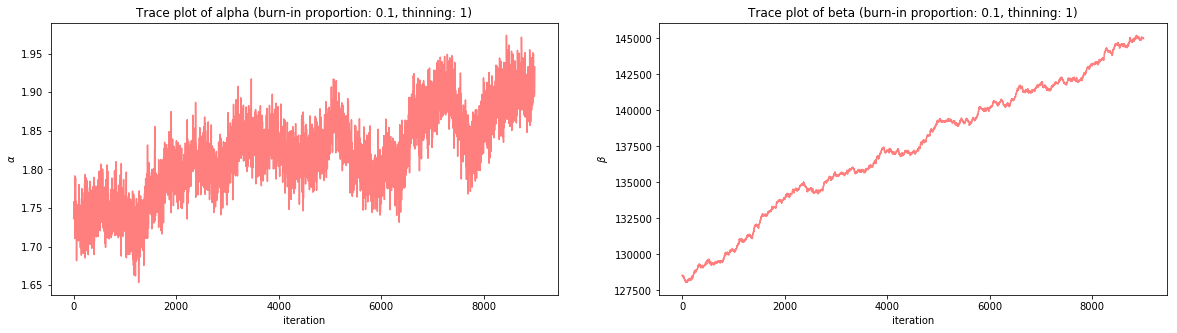

In [218]:
plot_samples(burnthin_samples, burn_in, thinning)

**3.** From the above trace plots for $\alpha,\beta$, it is made apparent that the sampler has not converged after 100000 iterations, given the suggested initializations. The trace plots for both parameters indicate high serial correlation and an unpward trend. This could be fixed by running the algorithm for a significantly higher number of iterations until the right mixing is achieved. If we still observe high spatial correlation after many sweeps, it might be an indication that the proposal distribution has too low variance, which would result in each proposed sample being very close to the current sample resulting in higher correlations between consecutive samples and in turn slower convergence.  If this is the case, we could try increasing the diagonal terms in the covariance matrix of the proposal distribution. 

At the same time, given the upward trend, we could initialize our sampler from higher values for $\alpha$ and $\beta$. 

Below, we provide the results after tweaking some of the settings of the sampler. For example, first, we increased the variance of $\beta$ parameter in the proposal distribution to 10000 and increased the number of samples to 1000000.

In [223]:
S=1000000
a_init = 1.54517349188
b_init = 133514.171939
Sigma = np.array([[0.1, 0],[0, 10000]])
a = 9
b = 6 
c = 9
d = 0.00001
burn_in = 0.1
thinning = 100

widerprop_samples = MH_in_gibbs(S, log_target, a_init, b_init, cancer_df, Sigma, a, b, c, d, burn_in, thinning)

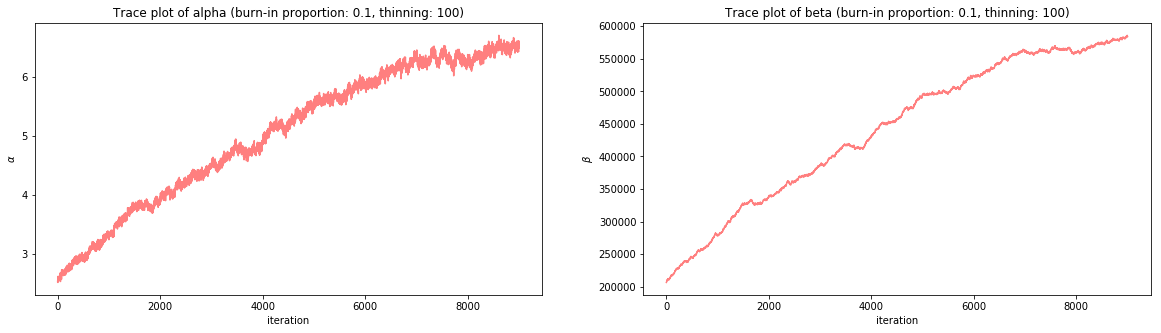

In [224]:
plot_samples(widerprop_samples, burn_in, thinning)

We can see that still both parameters indicate an upward trend but they jumped to higher values much faster. In the next experiment, we initialized both parameters at higher values ($\alpha=5.5, \beta=500000$) as indicated by the trends on the abobe trace plots but reduced the variances back to the original values to make smaller steps.

In [247]:
S=100000
a_init = 5.5
b_init = 500000
Sigma = np.array([[0.1, 0],[0, 1000]])
a = 9
b = 6 
c = 9
d = 0.00001
burn_in = 0.1
thinning = 10

changed_init_samples = MH_in_gibbs(S, log_target, a_init, b_init, cancer_df, Sigma, a, b, c, d, burn_in, thinning)

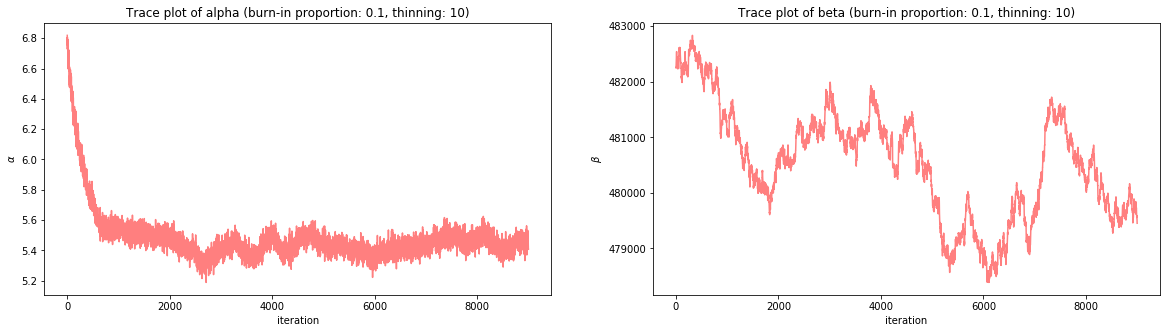

In [248]:
plot_samples(changed_init_samples, burn_in, thinning)

The trace plot of $\alpha$ indicates that the sampler achieves much better mixing when $\alpha$ is inialized at higher value around 5.5. However, it is also indicated that we need to increase our burn-in proportion since the first samples move sequentially towards the area of higher probability mass. 

The trace plot of $\beta$ also looks better when $\beta$ is initialized at a higher value but we can still spot some spatial correlation of longer downward trends followed by longer upward trends. 

Given that we seem to have found some realistic initiailization values, we can tweak the off-diagonal terms of the covariance matrix and increase the sweeps to 1000000.

The mean of the gamma distribution is $\frac{\alpha}{\beta}$. Hence, when we increase $\beta$ by much, $\alpha$ should also increase to make $\theta_j$ take more feasible values on average. Hence, we could encode this positive relationship in our proposal distribution by tweaking the off-diagonal terms of the covariance matrix. Below, we set the covariance between $\alpha$ and $\beta$ to 10 (which results in correlation equal to 0.1).

In [244]:
S=1000000
a_init = 5.5
b_init = 500000
Sigma = np.array([[0.1, 10],[10, 1000]])
a = 9
b = 6 
c = 9
d = 0.00001
burn_in = 0.2
thinning = 50

samples = MH_in_gibbs(S, log_target, a_init, b_init, cancer_df, Sigma, a, b, c, d, burn_in, thinning)

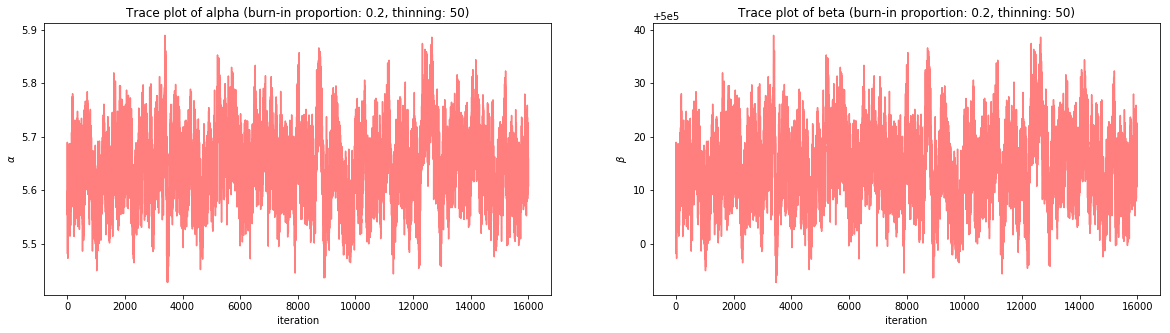

In [245]:
plot_samples(samples, burn_in, thinning)

**Note:** The y values on the y-axis of the right trace plot are reported in the format $y+500000$.

The above trace plots indicate that the sampler has converged, since the pattern seems random and no spatial correlation is observed. However, the trace plots do not provide a guarantee that the sampler has effectively sampled from the whole posterior distribution.